# Example: Optimal adversaries for dense MNIST model

This notebook gives an example where OMLT is used to find adversarial examples for a trained dense neural network. We follow the below steps:<br>
1.) A neural network with ReLU activation functions is trained to classify images from the MNIST dataset <br>
2.) OMLT is used to generate a mixed-integer encoding of the trained model using the big-M formulation <br>
3.) The model is optimized to find the maximum classification error (defined by an "adversarial" label) over a small input region <br>


## Library Setup
This notebook assumes you have a working PyTorch environment to train the neural network for classification. The neural network is then formulated in Pyomo using OMLT which therefore requires working Pyomo and OMLT installations.

The required Python libraries used this notebook are as follows: <br>
- `numpy`: used for manipulate input data <br>
- `torch`: the machine learning language we use to train our neural network
- `torchvision`: a package containing the MNIST dataset
- `pyomo`: the algebraic modeling language for Python, it is used to define the optimization model passed to the solver
- `onnx`: used to express trained neural network models
- `omlt`: the package this notebook demonstates. OMLT can formulate machine learning models (such as neural networks) within Pyomo

**NOTE:** This notebook also assumes you have a working MIP solver executable (e.g., CBC, Gurobi) to solve optimization problems in Pyomo. The open-source solver CBC is called by default.

In [12]:
#Import requisite packages
#data manipulation
import numpy as np
import tempfile

#pytorch for training neural network
import torch, torch.onnx
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

#pyomo for optimization
import pyomo.environ as pyo

#omlt for interfacing our neural network with pyomo
from omlt import OmltBlock
from omlt.neuralnet import FullSpaceNNFormulation
from omlt.io.onnx import write_onnx_model_with_bounds, load_onnx_neural_network_with_bounds

## Import the Data and Train a Neural Network

We begin by loading the MNIST dataset as `DataLoader` objects with pre-set training and testing batch sizes:


In [13]:
#set training and test batch sizes
train_kwargs = {'batch_size': 64}
test_kwargs = {'batch_size': 1000}

#build DataLoaders for training and test sets
dataset1 = datasets.MNIST('../data', train=True, download=True, transform=transforms.ToTensor())
dataset2 = datasets.MNIST('../data', train=False, transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

Next, we define the structure of the dense neural network model:

In [14]:
from torch import nn
hidden_size = 50

class NoSoftmaxNet(nn.Module):
    #define layers of neural network
    def __init__(self):
        super().__init__()
        self.hidden1  = nn.Linear(784, hidden_size)
        self.hidden2  = nn.Linear(hidden_size, hidden_size)
        self.output  = nn.Linear(hidden_size, 10)
        self.relu = nn.ReLU()

    #define forward pass of neural network
    def forward(self, x):
        x = self.hidden1(x)
        x = self.relu(x)
        x = self.hidden2(x)
        x = self.relu(x)
        x = self.output(x)
        return x

#create neural network without LogSoftmax and load parameters from existing model
model = NoSoftmaxNet()

In [15]:
import torch

# Path to the saved model
model_path = "classification_model.pth"

# Load the model
model = NoSoftmaxNet()
model.load_state_dict(torch.load(model_path))

print("Model loaded successfully.")

Model loaded successfully.


Next, we define an instance of the optimal adversary problem. We formulate the optimization problem as: <br>

$
\begin{align*} 
& \max_x \ y_k - y_j \\
& s.t. y_k = N_k(x) \\ 
&\quad |x - \bar{x}|_\infty \leq 0.05
\end{align*}
$

where $\bar{x}$ corresponds to an image in the test dataset with true label `j`, and $N_k(x)$ is the value of the neural network output corresponding to adversarial label `k` given input `x`. PyTorch needs to trace the model execution to export it to ONNX, so we also define a dummy input tensor `x_temp`.

In [16]:
#load image and true label from test set with index 'problem_index'
problem_index = 0
image = dataset2[problem_index][0].view(-1,28*28).detach().numpy()
label = dataset2[problem_index][1]

#define input region defined by infinity norm
epsilon_infty = 0.1
lb = np.maximum(0, image - epsilon_infty)
ub = np.minimum(1, image + epsilon_infty)

#save input bounds as dictionary
input_bounds = {}
for i in range(28*28):
    input_bounds[i] = (float(lb[0][i]), float(ub[0][i])) 
    
#define dummy input tensor    
x_temp = dataset2[problem_index][0].view(-1,28*28)

We can now export the PyTorch model as an ONNX model and use `load_onnx_neural_network_with_bounds` to load it into OMLT.

In [17]:
with tempfile.NamedTemporaryFile(suffix='.onnx', delete=False) as f:
    #export neural network to ONNX
    torch.onnx.export(
        model,
        x_temp,
        f,
        input_names=['input'],
        output_names=['output'],
        dynamic_axes={
            'input': {0: 'batch_size'},
            'output': {0: 'batch_size'}
        }
    )
    #write ONNX model and its bounds using OMLT
    write_onnx_model_with_bounds(f.name, None, input_bounds)
    #load the network definition from the ONNX model
    network_definition = load_onnx_neural_network_with_bounds(f.name)

As a sanity check before creating the optimization model, we can print the properties of the neural network layers from `network_definition`. This allows us to check input/output sizes, as well as activation functions.

In [18]:
for layer_id, layer in enumerate(network_definition.layers):
    print(f"{layer_id}\t{layer}\t{layer.activation}")

0	InputLayer(input_size=[784], output_size=[784])	linear
1	DenseLayer(input_size=[784], output_size=[50])	relu
2	DenseLayer(input_size=[50], output_size=[50])	relu
3	DenseLayer(input_size=[50], output_size=[10])	linear


Finally, we can load `network_definition` as a full-space `FullSpaceNNFormulation` object.

In [19]:
formulation = FullSpaceNNFormulation(network_definition)

## Solve Optimal Adversary Problem in Pyomo

We now encode the trained neural network in a Pyomo model from the `FullSpaceNNFormulation` object. 

In [20]:
#create pyomo model
m = pyo.ConcreteModel()

#create an OMLT block for the neural network and build its formulation
m.nn = OmltBlock()
m.nn.build_formulation(formulation) 

WARNING (W1002): Setting Var 'nn.scaled_inputs[202]' to a numeric value `0`
outside the bounds (0.229411780834198, 0.42941176891326904).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'nn.scaled_inputs[203]' to a numeric value `0`
outside the bounds (0.6254901885986328, 0.8254902362823486).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'nn.scaled_inputs[204]' to a numeric value `0`
outside the bounds (0.5235294103622437, 0.7235294580459595).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'nn.scaled_inputs[205]' to a numeric value `0`
outside the bounds (0.49215689301490784, 0.6921569108963013).
    See also https://pyomo.readthedocs.io/en/stable/errors.html#w1002
WARNING (W1002): Setting Var 'nn.scaled_inputs[206]' to a numeric value `0`
outside the bounds (0.135294109582901, 0.33529412746429443).
    See also https://pyomo.readthe

In [22]:
adversary = 3 
m.obj = pyo.Objective(expr=(-(m.nn.outputs[adversary]-m.nn.outputs[label])), sense=pyo.minimize)
pyo.SolverFactory('cbc').solve(m, tee=True)

Welcome to the CBC MILP Solver 
Version: 2.9.7 
Build Date: Oct 10 2015 
Revision Number: 2226 

command line - C:\CBC\win32-msvc12\bin\cbc.exe -printingOptions all -import C:\Users\HP\AppData\Local\Temp\tmpe36dt5t4.pyomo.lp -stat=1 -solve -solu C:\Users\HP\AppData\Local\Temp\tmpe36dt5t4.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 383 (-1725) rows, 1069 (-1623) columns and 40789 (-5517) elements
Statistics for presolved model
Original problem has 100 integers (100 of which binary)
Presolved problem has 89 integers (89 of which binary)
==== 1019 zero objective 51 different
==== absolute objective values 51 different
==== for integers 89 zero objective 1 different
89 variables have objective of 0
==== for integers absolute objective values 1 different
89 variables have objective of 0
===== end objective counts


Problem has 383 rows, 1069 columns (50 with objective) and 40789 elements
Column breakdown:
0 of type 0.0->inf, 777 of type 0.0

{'Problem': [{'Name': 'unknown', 'Lower bound': -3.93808344, 'Upper bound': -3.93808344, 'Number of objectives': 1, 'Number of constraints': 383, 'Number of variables': 1069, 'Number of binary variables': 100, 'Number of integer variables': 100, 'Number of nonzeros': 50, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'User time': -1.0, 'System time': 322.71, 'Wallclock time': 322.71, 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Statistics': {'Branch and bound': {'Number of bounded subproblems': 2753, 'Number of created subproblems': 2753}, 'Black box': {'Number of iterations': 620181}}, 'Error rc': 0, 'Time': 322.84205174446106}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [28]:
# print the output of the neural network 
# print the objective function

print(f"true label: {label}")
print(f"adversary label: {adversary}")

print()

for i in range(10):
    print(f"output {i}: {m.nn.outputs[i].value}", end = " ")
    print(f"Diff = {m.nn.outputs[i].value - m.nn.outputs[label].value}")

print()

print(f"objective function: {m.obj()}")

true label: 7
adversary label: 3

output 0: -8.0551162 Diff = -7.0038860000000005
output 1: -8.254617 Diff = -7.2033868
output 2: -2.4849374 Diff = -1.4337072000000002
output 3: 2.8868532 Diff = 3.9380834
output 4: -17.176897 Diff = -16.1256668
output 5: -4.7112148 Diff = -3.6599845999999996
output 6: -18.44712 Diff = -17.395889800000003
output 7: -1.0512302 Diff = 0.0
output 8: -5.6210273 Diff = -4.5697971
output 9: -5.7093594 Diff = -4.6581292

objective function: -3.9380834


In [34]:
# check if the results are correct

some_input = torch.zeros(28*28)
for i in range(28*28):
    some_input[i] = m.nn.inputs[i].value

some_output = model(some_input.view(-1,28*28))

for i in range(10):
    print(f"output {i}: {some_output[0][i].item()}", end = " ")
    print(f"Diff = {some_output[0][i].item() - some_output[0][label].item()}")

output 0: -8.055116653442383 Diff = -7.003886699676514
output 1: -8.254616737365723 Diff = -7.2033867835998535
output 2: -2.4849376678466797 Diff = -1.4337077140808105
output 3: 2.8868534564971924 Diff = 3.9380834102630615
output 4: -17.176897048950195 Diff = -16.125667095184326
output 5: -4.711215019226074 Diff = -3.659985065460205
output 6: -18.447118759155273 Diff = -17.395888805389404
output 7: -1.0512299537658691 Diff = 0.0
output 8: -5.62102746963501 Diff = -4.569797515869141
output 9: -5.709359169006348 Diff = -4.6581292152404785


## Adversarial Attack Explanation

- **Label**: This is the true output of the network.
- **Adversary**: This is another output of the network, specifically the class label directly following the true label in a cyclic sequence.
- **Objective**: We aim to minimize the difference between the logits of the true class (`logit_true`) and the adversary class (`logit_adversary`). The expression for this is `logit_true - logit_adversary`.

### Why Minimize This Difference?

By minimizing the expression `logit_true - logit_adversary`, we effectively maximize the error expressed as `logit_adversary - logit_true`. This strategy aims to find the smallest perturbation to the input image that leads to the largest error in classification. In simpler terms, it seeks to identify the least change necessary to fool the classifier into making the most confident wrong prediction.

### Implications

- **Perturbation**: The optimization finds a perturbation of the input image that results in the maximum misclassification error.
- **Optimal Solution**: While other perturbations might also cause classification errors, the solution derived from this approach yields the largest error.
- **Confidence Misplaced**: The key result is that this particular perturbation causes the classifier to have the highest confidence in an incorrect classification. The classifier is not only wrong but is also highly sure of its incorrect decision.


In [ ]:
max_classification_error_check = False 
if max_classification_error_check:
    
    max_classification_error = np.inf
    most_adv_label = None

    for adversary in range(10):
        
        if adversary == label:
            continue
        m.obj = pyo.Objective(expr=(-(m.nn.outputs[adversary]-m.nn.outputs[label])), sense=pyo.minimize)
        pyo.SolverFactory('cbc').solve(m, tee=True)
        print(f"objective function: {m.obj()}")

        if m.obj() < max_classification_error:
            max_classification_error = m.obj()
            most_adv_label = adversary

Welcome to the CBC MILP Solver 
Version: 2.9.7 
Build Date: Oct 10 2015 
Revision Number: 2226 

command line - C:\CBC\win32-msvc12\bin\cbc.exe -printingOptions all -import C:\Users\HP\AppData\Local\Temp\tmpdhsg9kvn.pyomo.lp -stat=1 -solve -solu C:\Users\HP\AppData\Local\Temp\tmpdhsg9kvn.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 400 (-1708) rows, 1084 (-1608) columns and 42500 (-3806) elements
Statistics for presolved model
Original problem has 100 integers (100 of which binary)
Presolved problem has 100 integers (100 of which binary)
==== 1034 zero objective 51 different
==== absolute objective values 51 different
==== for integers 100 zero objective 1 different
100 variables have objective of 0
==== for integers absolute objective values 1 different
100 variables have objective of 0
===== end objective counts


Problem has 400 rows, 1084 columns (50 with objective) and 42500 elements
Column breakdown:
0 of type 0.0->inf, 813 of typ

In [ ]:
if max_classification_error_check:

    # print the most adversarial label and the corresponding classification error

    print(f"Most adversarial label: {most_adv_label}")
    print(f"Classification error: {max_classification_error}")

Most adversarial label: 3
Classification error: 4.48189916


### visualize the image

In [ ]:
label

7

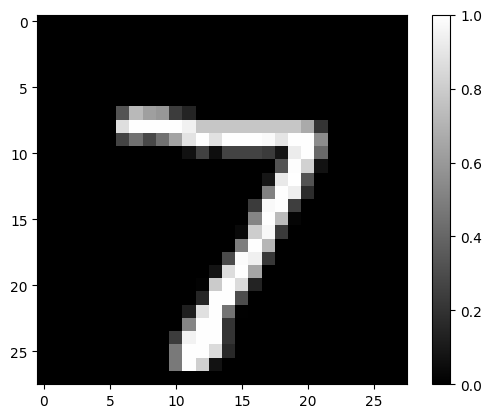

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'image_data' is your 28x28 array
image_data = image.reshape(28,28) # your 28x28 numpy array goes here

plt.imshow(image_data, cmap='gray')  # Use cmap='gray' for grayscale images
plt.colorbar()  # Optionally add a colorbar to see the intensity scale
plt.show()